In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
SEED = 20240207
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [5]:
transform_aug = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [6]:
train_no_aug = datasets.MNIST(root='./data', train=True, download=True, transform=transform_no_aug)
train_aug    = datasets.MNIST(root='./data', train=True, download=True, transform=transform_aug)
test_data    = datasets.MNIST(root='./data', train=False, download=True, transform=transform_no_aug)

train_loader_no_aug = DataLoader(train_no_aug, batch_size=64, shuffle=True)
train_loader_aug    = DataLoader(train_aug, batch_size=64, shuffle=True)
test_loader         = DataLoader(test_data, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


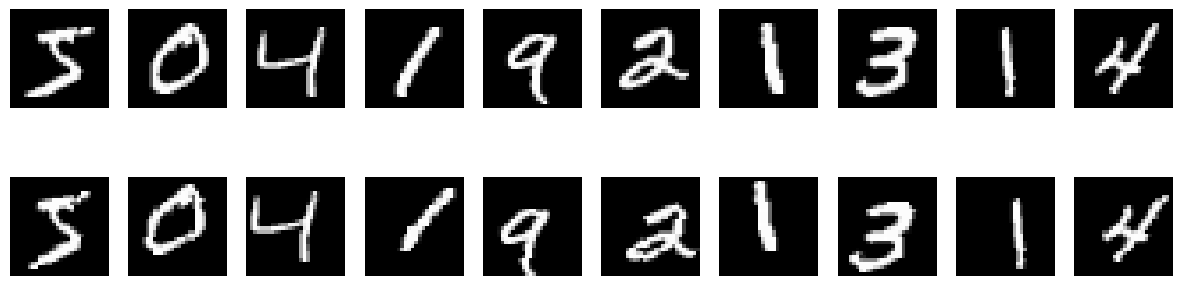

In [7]:
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(10):
    img, _ = train_no_aug[i]
    axes[0, i].imshow(img.squeeze(), cmap='gray')
    axes[0, i].axis('off')

    img_aug, _ = train_aug[i]
    axes[1, i].imshow(img_aug.squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Augmented", fontsize=12)
plt.show()


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [9]:
def train_model(model, loader, optimizer, criterion):
    model.train()
    correct, total = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total


def test_model(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [10]:
model_no_aug = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_no_aug.parameters(), lr=0.001)

acc_no_aug = []

for epoch in range(10):
    train_acc = train_model(model_no_aug, train_loader_no_aug, optimizer, criterion)
    test_acc = test_model(model_no_aug, test_loader)
    acc_no_aug.append(test_acc)
    print(f"Epoch {epoch+1}: Test Accuracy = {test_acc:.2f}%")


Epoch 1: Test Accuracy = 98.30%
Epoch 2: Test Accuracy = 98.95%
Epoch 3: Test Accuracy = 98.95%
Epoch 4: Test Accuracy = 99.10%
Epoch 5: Test Accuracy = 99.17%
Epoch 6: Test Accuracy = 99.29%
Epoch 7: Test Accuracy = 99.25%
Epoch 8: Test Accuracy = 99.12%
Epoch 9: Test Accuracy = 99.25%
Epoch 10: Test Accuracy = 99.14%


In [11]:
model_aug = CNN().to(device)
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

acc_aug = []

for epoch in range(10):
    train_acc = train_model(model_aug, train_loader_aug, optimizer, criterion)
    test_acc = test_model(model_aug, test_loader)
    acc_aug.append(test_acc)
    print(f"Epoch {epoch+1}: Test Accuracy = {test_acc:.2f}%")


Epoch 1: Test Accuracy = 98.64%
Epoch 2: Test Accuracy = 98.99%
Epoch 3: Test Accuracy = 98.92%
Epoch 4: Test Accuracy = 99.02%
Epoch 5: Test Accuracy = 99.16%
Epoch 6: Test Accuracy = 99.32%
Epoch 7: Test Accuracy = 99.36%
Epoch 8: Test Accuracy = 99.21%
Epoch 9: Test Accuracy = 99.33%
Epoch 10: Test Accuracy = 99.34%


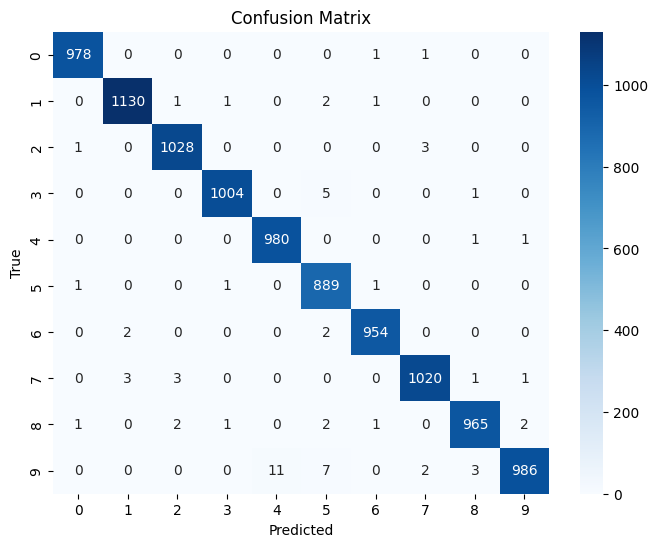

In [12]:
model = model_aug
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


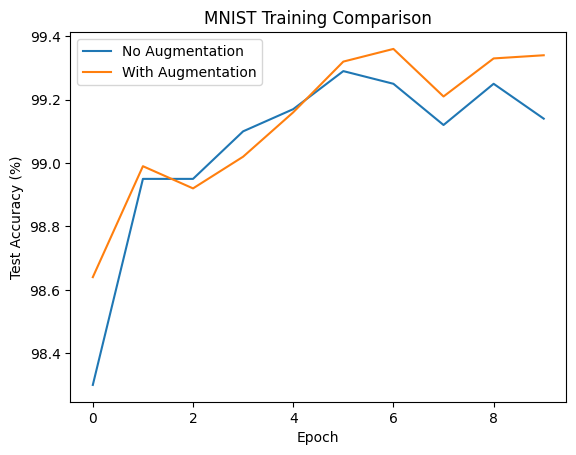

In [13]:
plt.plot(acc_no_aug, label="No Augmentation")
plt.plot(acc_aug, label="With Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.title("MNIST Training Comparison")
plt.show()


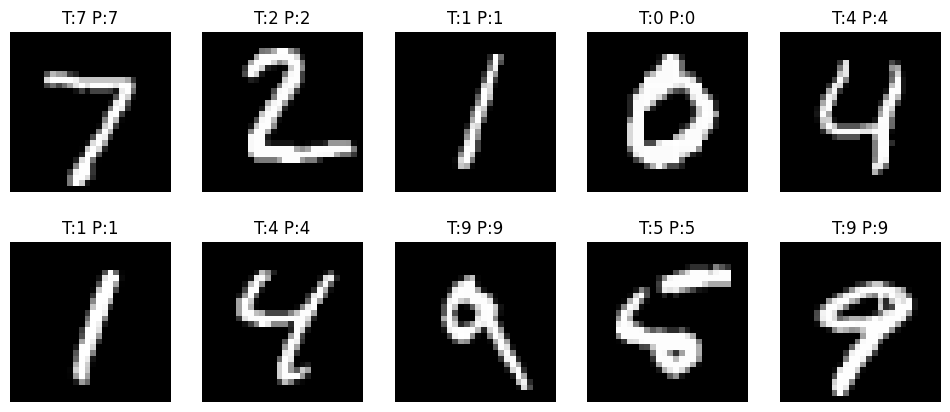

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    img, label = test_data[i]
    img_input = img.unsqueeze(0).to(device)

    output = model(img_input)
    pred = output.argmax(1).item()

    axes[i//5, i%5].imshow(img.squeeze(), cmap='gray')
    axes[i//5, i%5].set_title(f"T:{label} P:{pred}")
    axes[i//5, i%5].axis('off')

plt.show()
